<a href="https://colab.research.google.com/github/antoniomuso/speech2face/blob/master/NewDecoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
vox1_path = "/content/drive/My Drive/Speech2Face/vox1_dataset/"
img = vox1_path+"unzippedFaces"
! pip3 install face_recognition


In [3]:
# !wget http://www.robots.ox.ac.uk/~vgg/research/CMBiometrics/data/zippedFaces.tar.gz 
# !tar zxvf zippedFaces.tar.gz -C "/content/drive/My Drive/Speech2Face/vox1_dataset/"

In [4]:
# !curl --user voxceleb1912:0s42xuw6 -o "/content/drive/My Drive/Speech2Face/ff/vox.zip" http://www.robots.ox.ac.uk/~vgg/data/voxceleb/vox1a/vox1_test_wav.zip

In [5]:
import glob

import numpy as np
import sys

from PIL import Image
from torch.utils.data import Dataset
import  torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from face_recognition import face_landmarks, face_locations, face_encodings


def load_metadata(data_file_path):
    data_list = []
    with open(data_file_path, "r") as f:
        for line in f:
            data_list.append(line.rstrip("\n").split(","))
    return data_list


class _Normalize_Tensor(object):
    def __init__(self, color_mean, color_std):
        self.color_mean = color_mean
        self.color_std = color_std

    def __call__(self, img):
        # Convert image to Tensor
        img = transforms.functional.to_tensor(img)

        # Normalize image by the parameter of pre-trained face-encoder
        img = transforms.functional.normalize(
            img, self.color_mean, self.color_std)

        return img

class EmbedImagePairs(Dataset):
    def __init__(self, data_list_path, face_encoder, mean, std, device, size=64):
        super().__init__()
        self.images = ImageFolder(data_list_path)

        self.face_encoder = face_encoder

        self.color_mean = mean
        self.color_std = std
        
        self.device = device
        self.size = size

        # Transform input for face-encoder
        self.transform_fe = transforms.Compose([
            transforms.Resize((224, 224)),
            _Normalize_Tensor(self.color_mean, self.color_std)
        ])

        self.transform_fd = transforms.Compose([
            transforms.Resize((self.size, self.size)),
            transforms.ToTensor()
        ])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Load face-image
        image = self.images[idx][0]

        # convert face-images into 4096-dim vectors
        self.face_encoder.eval()

        np_image = np.array(image)

        # Localize Face
        face_loc = face_locations(np_image)

        if len(face_loc) != 0:
          x,y1,x1,y = face_loc[0]
          image = image.crop((x,y,x1,y1))

        face_vectors = self.face_encoder(
            self.transform_fe(image).unsqueeze_(0).to(self.device))

        image_ = self.transform_fd(image)

        return face_vectors, image_

In [6]:
import torch
import torch.nn as nn


class Vgg_face_dag(nn.Module):

    def __init__(self):
        super(Vgg_face_dag, self).__init__()
        self.meta = {'mean': [129.186279296875, 104.76238250732422, 93.59396362304688],
                     'std': [1, 1, 1],
                     'imageSize': [224, 224, 3]}
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.fc6 = nn.Linear(in_features=25088, out_features=4096, bias=True)
        self.relu6 = nn.ReLU(inplace=True)
        self.dropout6 = nn.Dropout(p=0.5)
        self.fc7 = nn.Linear(in_features=4096, out_features=4096, bias=True)
        self.relu7 = nn.ReLU(inplace=True)
        self.dropout7 = nn.Dropout(p=0.5)
        self.fc8 = nn.Linear(in_features=4096, out_features=2622, bias=True)

    def forward(self, x0, is_fc8=False):
        x1 = self.conv1_1(x0)
        x2 = self.relu1_1(x1)
        x3 = self.conv1_2(x2)
        x4 = self.relu1_2(x3)
        x5 = self.pool1(x4)
        x6 = self.conv2_1(x5)
        x7 = self.relu2_1(x6)
        x8 = self.conv2_2(x7)
        x9 = self.relu2_2(x8)
        x10 = self.pool2(x9)
        x11 = self.conv3_1(x10)
        x12 = self.relu3_1(x11)
        x13 = self.conv3_2(x12)
        x14 = self.relu3_2(x13)
        x15 = self.conv3_3(x14)
        x16 = self.relu3_3(x15)
        x17 = self.pool3(x16)
        x18 = self.conv4_1(x17)
        x19 = self.relu4_1(x18)
        x20 = self.conv4_2(x19)
        x21 = self.relu4_2(x20)
        x22 = self.conv4_3(x21)
        x23 = self.relu4_3(x22)
        x24 = self.pool4(x23)
        x25 = self.conv5_1(x24)
        x26 = self.relu5_1(x25)
        x27 = self.conv5_2(x26)
        x28 = self.relu5_2(x27)
        x29 = self.conv5_3(x28)
        x30 = self.relu5_3(x29)
        x31_preflatten = self.pool5(x30)
        x31 = x31_preflatten.view(x31_preflatten.size(0), -1)
        x32 = self.fc6(x31)
        x33 = self.relu6(x32)
        x34 = self.dropout6(x33)
        x35 = self.fc7(x34)
        x36 = self.relu7(x35)
        x37 = self.dropout7(x36)
        if is_fc8:
            x38 = self.fc8(x37)
        else:
            x38 = x37
        return x38


def vgg_face_dag(weights_path=None, **kwargs):
    """
    load imported model instance
    Args:
        weights_path (str): If set, loads model weights from the given path
    """
    model = Vgg_face_dag()
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
    return model

In [7]:
import torch
import torch.nn.functional as F
from torch import nn

class Generator(nn.Module):
    def __init__(self, n_hidden, bottom_width=4, channels=512):
        super().__init__()
        self.channels = channels
        self.bottom_width = bottom_width

        self.linear = nn.Linear(n_hidden, bottom_width*bottom_width*channels)
        self.dconv1 = nn.ConvTranspose2d(channels, channels // 2, 4, 2, 1)
        self.dconv2 = nn.ConvTranspose2d(channels // 2, channels // 4, 4, 2, 1)
        self.dconv3 = nn.ConvTranspose2d(channels // 4, channels // 8, 4, 2, 1)
        self.dconv4 = nn.ConvTranspose2d(channels // 8, 3, 4, 2, 1)

        self.bn0 = nn.BatchNorm1d(bottom_width*bottom_width*channels)
        self.bn1 = nn.BatchNorm2d(channels // 2)
        self.bn2 = nn.BatchNorm2d(channels // 4)
        self.bn3 = nn.BatchNorm2d(channels // 8)

    def forward(self, x):
        x = F.relu(self.bn0(self.linear(x))).view(-1, self.channels, self.bottom_width, self.bottom_width)
        x = F.relu(self.bn1(self.dconv1(x)))
        x = F.relu(self.bn2(self.dconv2(x)))
        x = F.relu(self.bn3(self.dconv3(x)))

        x = torch.sigmoid(self.dconv4(x))

        return x

In [8]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms
        
    def __call__(self, x):
        for t in self.transforms:
            x = t(x)
        return x
    
class Resize(object):
    def __init__(self, input_size):
        self.input_size = input_size
        
    def __call__(self, img):
        img = img.resize((self.input_size, self.input_size),
                                Image.BICUBIC)
        return img
    
class Normalize_Tensor(object):
    def __init__(self, color_mean, color_std):
        self.color_mean = color_mean
        self.color_std = color_std

    def __call__(self, img):

        # PIL画像をTensorに。大きさは最大1に規格化される
        img = transforms.functional.to_tensor(img)

        # 色情報の標準化
        img = transforms.functional.normalize(
            img, self.color_mean, self.color_std)

        return img

class ImageTransform():
    def __init__(self, input_size, color_mean, color_std):
        self.data_transform = {
            'train' : Compose([
                Resize(input_size),
                Normalize_Tensor(color_mean, color_std)
            ]),
            'val' : Compose([
                Resize(input_size),
                Normalize_Tensor(color_mean, color_std)
            ])
        }
    
    def __call_(self, phase, img):
        return self.data_transform[phase](img)

In [9]:
from torch import nn, optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Set Model
model = Generator(4096).to(device)
print('Created Generator')
# Set loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

Created Generator


Image Pairing


  0%|          | 0/151 [00:00<?, ?it/s]

Creating dataloader
Start Training


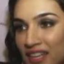

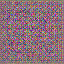

loss: 10.853019714355469 Steps: 128/158093


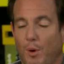

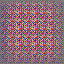

loss: 10.538536071777344 Steps: 256/158093


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-b606d655756b>", line 125, in <module>
    train(model, trn_dataloader, criterion, optimizer, device, output_dir_name, num_epochs=num_epochs)
  File "<ipython-input-10-b606d655756b>", line 88, in train
    trn_loss = train_epoch(model, dataloaders, criterion, optimizer, device)
  File "<ipython-input-10-b606d655756b>", line 46, in train_epoch
    for x, y in trn_dataloader:
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 363, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 403, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/fetch.py", line 44, in fe

KeyboardInterrupt: ignored

In [10]:
import argparse
import os
from os.path import join

import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from tqdm import tqdm
from google.colab.patches import cv2_imshow
import cv2


#from dataloader import EmbedImagePairs
#from face_encoder_model import vgg_face_dag
#from face_decoder_model import Generator


global_epoch = 0

#def _save_model(epoch, model, optimizer, fname):
#    torch.save({
#        'epoch': epoch,
#        'model_state_dict': model.state_dict(),
#        'optimizer_state_dict': optimizer.state_dict(),
#        }, join(output_dir_name, 'epoch_{}.pth'.format(epoch)))

def _save_model(epoch, model, optimizer, steps):
    torch.save({
        'steps': steps,
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }, join(output_dir_name, 'epoch_{}_steps_{}.pth'.format(epoch, steps)))

saving_steps = 2
output_dir_name_g = "/content/drive/My Drive/Speech2Face/models/face_decoder/"

def train_epoch(model, trn_dataloader, criterion, optimizer, device):
    model.train()

    running_loss = 0
    dataset_len = len(trn_dataloader.dataset)

    count = 0
    numOfElements = 0
    for x, y in trn_dataloader:
        count += 1
        x = x.squeeze().to(device)  

        y_img = cv2.cvtColor(np.einsum('abc->bca',y[0].numpy()*255),cv2.COLOR_BGR2RGB)
        cv2_imshow(y_img)

        y = y.to(device)

        optimizer.zero_grad()

        outputs = model(x)

        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        o_img = cv2.cvtColor(np.einsum('abc->bca',outputs[0].cpu().detach().numpy()*255),cv2.COLOR_BGR2RGB)
        cv2_imshow(o_img)
        running_loss += loss.item() * x.size(0)
        numOfElements += x.shape[0]
        print("loss:", running_loss / count, "Steps:", str(numOfElements) + "/" + str(dataset_len) )

        if (numOfElements % (x.shape[0] * saving_steps)) == 0:
          _save_model(global_epoch+1, model, optimizer, numOfElements)

    
    trn_loss = running_loss/len(trn_dataloader.dataset)
    
    return trn_loss


def train(model, dataloaders, criterion, optimizer, device, output_dir_name, num_epochs=100):
    trn_losses = []

    # make dir where trained model saved
    os.makedirs(output_dir_name, exist_ok=True)

    # start at zero, end at num_epochs (including)
    print("Start Training")
    for epoch in tqdm(range(global_epoch, num_epochs+1)):
        # Training phase
        trn_loss = train_epoch(model, dataloaders, criterion, optimizer, device)
        trn_losses += [trn_loss]
        print("Epoch: {}  || Loss: {}".format(epoch, trn_loss))
    
        _save_model(epoch, model, optimizer, output_dir_name)


base_dir='/content/drive/My Drive/Speech2Face/'
input="vox1_dataset/unzippedFaces"
batch_size=128
num_epochs=150
checkpoint_path=None




# Load face-encoder model
face_encoder_path = join(base_dir, "Pretrained", "vgg_face_dag.pth")
face_encoder_model = vgg_face_dag(face_encoder_path).to(device)
color_mean, color_std = face_encoder_model.meta["mean"], face_encoder_model.meta["std"]
color_mean = [tmp / 255.0 for tmp in color_mean]
color_std = [tmp / 255.0 for tmp in color_std]

# Set DataLoader
input_path = join(base_dir, input)
print('Image Pairing')
dataset = EmbedImagePairs(input_path, face_encoder_model,
                          color_mean, color_std, device)
print('Creating dataloader')
trn_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
output_dir_name = join(base_dir, "models", "face_decoder")
if checkpoint_path:
    checkpoint = torch.load(checkpoint_path)
    global_epoch = checkpoint["epoch"]
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
# Train
train(model, trn_dataloader, criterion, optimizer, device, output_dir_name, num_epochs=num_epochs)
print("Finish training")

In [ ]:
#_save_model(1, model, optimizer, 'new_decoder_15360')